# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

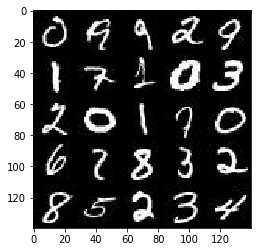

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

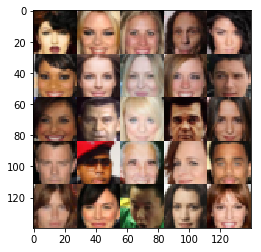

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 32, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 64, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=reuse)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 128, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=reuse)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    alpha=0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 1*1*256)
        x1 = tf.reshape(x1, (-1, 1, 1, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=7, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.7683
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 2.0305
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 2.5631
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 2.7865
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 2.9372
Epoch 1/2... Discriminator Loss: 0.5758... Generator Loss: 3.5568
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 3.4824
Epoch 1/2... Discriminator Loss: 0.4333... Generator Loss: 3.8588
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 3.6994


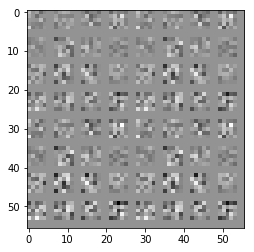

Epoch 1/2... Discriminator Loss: 0.2642... Generator Loss: 3.8723
Epoch 1/2... Discriminator Loss: 0.1945... Generator Loss: 3.7301
Epoch 1/2... Discriminator Loss: 0.1344... Generator Loss: 4.1889
Epoch 1/2... Discriminator Loss: 0.1000... Generator Loss: 4.0997
Epoch 1/2... Discriminator Loss: 0.0686... Generator Loss: 4.4844
Epoch 1/2... Discriminator Loss: 0.0514... Generator Loss: 4.6067
Epoch 1/2... Discriminator Loss: 0.0379... Generator Loss: 4.7849
Epoch 1/2... Discriminator Loss: 0.0316... Generator Loss: 4.8431
Epoch 1/2... Discriminator Loss: 0.0262... Generator Loss: 4.9807
Epoch 1/2... Discriminator Loss: 0.0207... Generator Loss: 5.3140


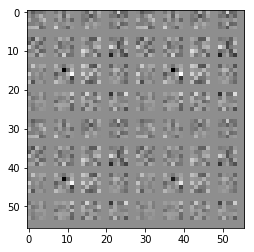

Epoch 1/2... Discriminator Loss: 0.0173... Generator Loss: 5.4090
Epoch 1/2... Discriminator Loss: 0.0141... Generator Loss: 5.5620
Epoch 1/2... Discriminator Loss: 0.0129... Generator Loss: 5.5700
Epoch 1/2... Discriminator Loss: 0.0112... Generator Loss: 5.6772
Epoch 1/2... Discriminator Loss: 0.0114... Generator Loss: 5.4812
Epoch 1/2... Discriminator Loss: 0.0111... Generator Loss: 5.2860
Epoch 1/2... Discriminator Loss: 0.0096... Generator Loss: 5.5111
Epoch 1/2... Discriminator Loss: 0.0091... Generator Loss: 5.5381
Epoch 1/2... Discriminator Loss: 0.0076... Generator Loss: 5.7071
Epoch 1/2... Discriminator Loss: 0.0074... Generator Loss: 5.6504


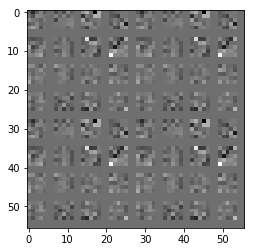

Epoch 1/2... Discriminator Loss: 0.0072... Generator Loss: 5.6614
Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 5.7792
Epoch 1/2... Discriminator Loss: 0.0060... Generator Loss: 5.7810
Epoch 1/2... Discriminator Loss: 0.0055... Generator Loss: 5.8934
Epoch 1/2... Discriminator Loss: 0.0056... Generator Loss: 5.8141
Epoch 1/2... Discriminator Loss: 0.0055... Generator Loss: 5.8246
Epoch 1/2... Discriminator Loss: 0.0045... Generator Loss: 6.0185
Epoch 1/2... Discriminator Loss: 0.0040... Generator Loss: 6.2977
Epoch 1/2... Discriminator Loss: 0.0032... Generator Loss: 6.6151
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 6.8648


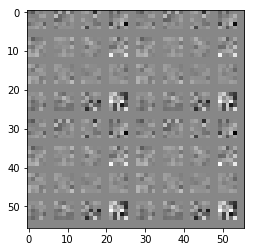

Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 6.9757
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 7.0816
Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 7.2051
Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 7.1875
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 7.3070
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 7.2940
Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 7.2649
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 7.1851
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 7.1918
Epoch 2/2... Discriminator Loss: 0.0017... Generator Loss: 7.1730


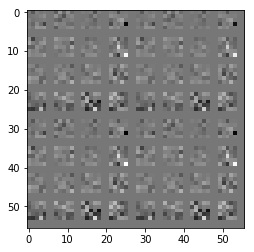

Epoch 2/2... Discriminator Loss: 0.0017... Generator Loss: 7.3114
Epoch 2/2... Discriminator Loss: 0.0016... Generator Loss: 7.2467
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 7.0470
Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 6.8856
Epoch 2/2... Discriminator Loss: 0.0017... Generator Loss: 6.9271
Epoch 2/2... Discriminator Loss: 0.0016... Generator Loss: 7.0597
Epoch 2/2... Discriminator Loss: 0.0016... Generator Loss: 7.0963
Epoch 2/2... Discriminator Loss: 0.0016... Generator Loss: 7.0891
Epoch 2/2... Discriminator Loss: 0.0015... Generator Loss: 7.1401
Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 6.7448


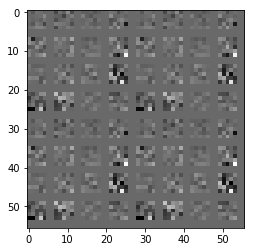

Epoch 2/2... Discriminator Loss: 0.0016... Generator Loss: 6.9491
Epoch 2/2... Discriminator Loss: 0.0014... Generator Loss: 7.1257
Epoch 2/2... Discriminator Loss: 0.0013... Generator Loss: 7.3115
Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 7.4498
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.4796
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.5507
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.5218
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.3953
Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 7.3390
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.3208


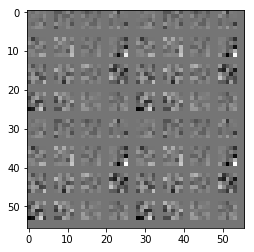

Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 7.3080
Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 7.2565
Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 7.2263
Epoch 2/2... Discriminator Loss: 0.0013... Generator Loss: 7.2342
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.2641
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.3130
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.3461
Epoch 2/2... Discriminator Loss: 0.0010... Generator Loss: 7.3975
Epoch 2/2... Discriminator Loss: 0.0010... Generator Loss: 7.3871
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 7.5317


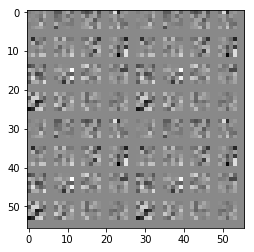

Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 7.6269
Epoch 2/2... Discriminator Loss: 0.0008... Generator Loss: 7.6590
Epoch 2/2... Discriminator Loss: 0.0008... Generator Loss: 7.7110
Epoch 2/2... Discriminator Loss: 0.0008... Generator Loss: 7.7433
Epoch 2/2... Discriminator Loss: 0.0008... Generator Loss: 7.7933
Epoch 2/2... Discriminator Loss: 0.0008... Generator Loss: 7.6768
Epoch 2/2... Discriminator Loss: 0.0010... Generator Loss: 7.4141
Epoch 2/2... Discriminator Loss: 0.0010... Generator Loss: 7.3203
Epoch 2/2... Discriminator Loss: 0.0010... Generator Loss: 7.3287
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 7.4426


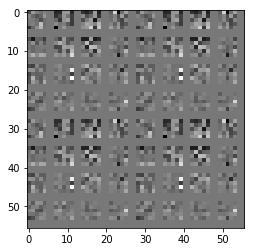

Epoch 2/2... Discriminator Loss: 0.0008... Generator Loss: 7.5550
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 7.5256
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 7.3730


In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.7597
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 2.5094
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 3.1414
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 3.1442
Epoch 1/1... Discriminator Loss: 0.2715... Generator Loss: 3.3799
Epoch 1/1... Discriminator Loss: 0.2175... Generator Loss: 3.7151


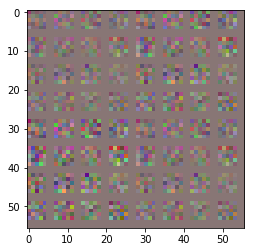

Epoch 1/1... Discriminator Loss: 0.1643... Generator Loss: 3.6548
Epoch 1/1... Discriminator Loss: 0.1483... Generator Loss: 3.6271
Epoch 1/1... Discriminator Loss: 0.0943... Generator Loss: 4.0876
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 4.0705
Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 4.1876
Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 4.1119
Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 4.4212
Epoch 1/1... Discriminator Loss: 0.0358... Generator Loss: 4.6050
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 4.4942
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 4.6062


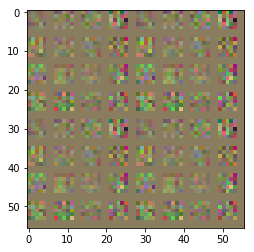

Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 4.7499
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 5.1221
Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 5.2680
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 5.2493
Epoch 1/1... Discriminator Loss: 0.0168... Generator Loss: 5.1932
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 5.1258
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 5.1637
Epoch 1/1... Discriminator Loss: 0.0130... Generator Loss: 5.1380
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.2445
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 5.3902


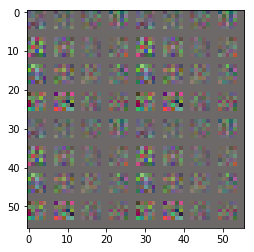

Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.4217
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 5.5868
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 5.7119
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 5.8437
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 5.9784
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.0913
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 6.1954
Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 6.2078
Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 6.1886
Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 6.2664


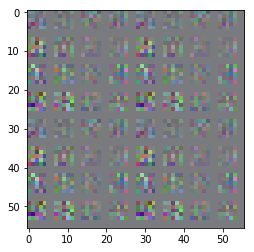

Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 6.3113
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 6.4017
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 6.4707
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.6317
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 6.5868
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.6541
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 6.7377
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.7318
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 6.6805
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.7028


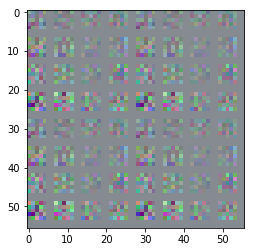

Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.7487
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.8047
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 6.7905
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 6.7739
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.8827
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.9438
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.9779
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 6.9606
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.9484
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 7.0547


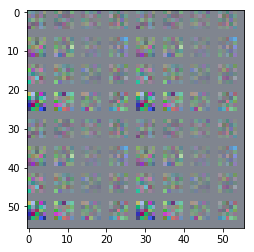

Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 7.1457
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 7.2600
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.3982
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.4128
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.5136
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 7.5597
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.6526
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 7.6971
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.7381
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.7015


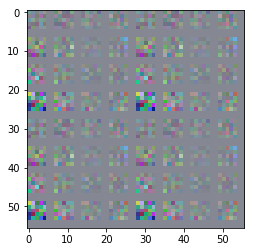

Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.6628
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.6081
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.5780
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.6051
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.7184
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.6329
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.6304
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.5771
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.5941
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.4537


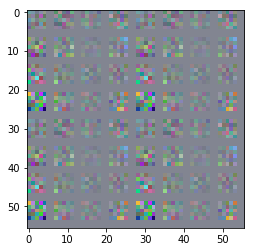

Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.4204
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 7.3252
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.2014
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.3014
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.2267
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.2351
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.1992
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.1909
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.2000
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.2991


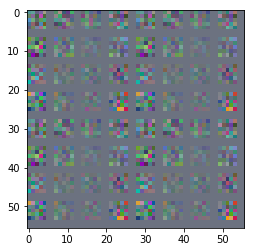

Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.4664
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.4903
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.5975
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.6518
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.7145
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.7705
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.8155
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.8935
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.9485
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.9781


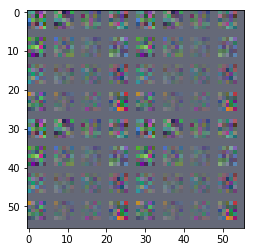

Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.9740
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.0065
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.0137
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.0004
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.0739
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.9759
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.0458
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.0529
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.0103
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.0079


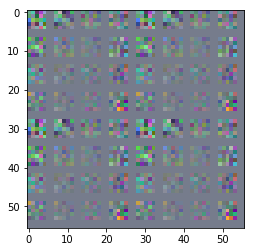

Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 8.0296
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.0754
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.1355
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.1549
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.2092
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.2474
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.3434
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.3356
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.3965
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.4194


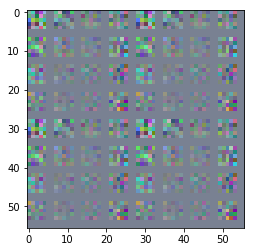

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.4977
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.5350
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.5731
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.5972
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6349
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6322
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6578
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.6857
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7107
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.6930


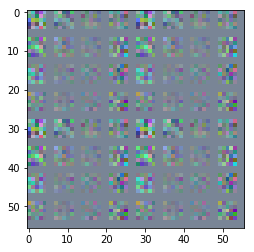

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6879
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7332
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.6954
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7362
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7080
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7007
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.7172
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7464
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.8086
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.8016


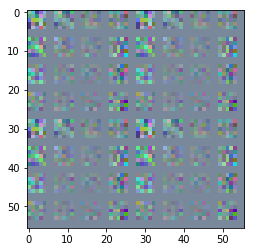

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.8328
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9004
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9299
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8880
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9057
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9269
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9430
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9716
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 9.0156
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9694


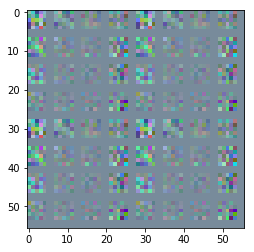

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9845
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0534
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 9.0211
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0568
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 9.1197
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9812
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9518
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.9647


In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.